# Creating Household Profiles based on Regulatory Settings

In this notebook, we create optimized household load profiles, based on given regulatory settings. The results are saved in the output folder, where they are later picked up for the grid analysis and the initial analysis of the aggregated profiles.

In [411]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB, quicksum
import matplotlib.pyplot as plt
import os

In [412]:
print(gp.gurobi.version())

(9, 5, 0)


In [413]:
# In a first step, the input prices are loaded. We take day-ahead German spot market prices
# read EV data with multi-column index
df = pd.read_csv("./input/Hourly_EV_Charging.csv", sep=";", header=[0,1], index_col=0) # only for index, the actual EV data is handled separately
df.index = pd.to_datetime(df.index)

df_price = pd.read_excel("./input/Gro_handelspreise_201901010000_201912312359_Stunde.xlsx", skiprows=9)
df_p = pd.DataFrame()
df_p.index = df.index
# MWh prices are transformed to kWh prices
df_p["Deutschland/Luxemburg [€/kWh]"] = df_price["Deutschland/Luxemburg [€/MWh]"].apply(lambda x: x/1000).values
min_price = df_p["Deutschland/Luxemburg [€/kWh]"].min()
df_p["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+abs(min_price)) # avoid negative values for optimization
df_p.head()

/Users/leosemmelmann/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Deutschland/Luxemburg [€/kWh]
2019-01-01 00:00:00+00:00,0.11833
2019-01-01 01:00:00+00:00,0.10008
2019-01-01 02:00:00+00:00,0.08593
2019-01-01 03:00:00+00:00,0.08010
2019-01-01 04:00:00+00:00,0.08260


In [414]:
# Now, we also load the 1kW nominal capacity PV generation in Hamelin
df_pv = pd.read_csv("./input/ninja_pv_52.1040_9.3562_uncorrected.csv",skiprows=3)

In [415]:
# Here, we load dataframes with 500 EV, HH and HP profiles. The household config decides which configuration per household is selected
df_ev = pd.read_pickle("./input/2019 Hamelin 500 EV.pkl")
df_hh = pd.read_pickle("./input/2019 Hamelin 500 HH.pkl")
df_hp = pd.read_pickle("./input/2019 Hamelin 500 HP.pkl")
household_config = pd.read_pickle("./input/2019 Hamelin Household Configuration.pkl")

In [416]:
# We use this function to later easily access the outputs of the Gurobi model

def get_results_in_df(m, variableNames, n_timesteps): #  "def name(argumente)" zeigt den Anfang einer Funktion an, die ich später beliebig aufrufen kann
   
    results_df = pd.DataFrame(columns = variableNames, index = [t for t in range(n_timesteps)] )   # Hier wird ein leeres DataFrame erstellt, dass als Spalteneinträge die Namen der Gutobi-variablen hat und als Zeilen die Zeitschritte der Entscheidungsvariablen

    for n in variableNames:                                         #Iteration über alle Zielvariablen
        for t in range(n_timesteps):                                #Iteration über alle Zeitschritte
            VarName = n + f"[{t}]"                                  #Hier wird ein String erstellt, der die Form n[t] hat. Mit diesem wird später die Zielvariable ausgelesen
            try:                                                    #try - except ist eine hilfreiche Methdoe, um Fehler abzufangen. Wenn in der nächsten Zeile ein error passiert, bspw. wegen eines Schreibfehlers in meinen zielvariablen, wird die Funktion nicht abgebrochen sondern weiter ausgeführt.
                results_df.loc[t][n] = m.getVarByName(VarName).x    #Auslesen der Zielvariable
            except:
                pass
    return results_df                                               #Hier wird festgelegt, was zurückgegeben wird wenn die Funktion aufgerufen wird. In diesem Fall geben wir das fertige DataFrame mit den ergebnissen der Optimierung zurück

In [417]:
#### Components removed
#handling_fee = 0.02 # https://support.tibber.com/de/articles/4406583-wie-setzt-sich-der-monatliche-tibber-preis-zusammen - removed, previously price component


In [418]:
# we need this function for the rotating grid charge type
def adjust_grid_charges(length, grid_charges, starting_point):
    grid_charges_final = np.full(length, grid_charges/2)  
    offset = starting_point % 2  #starting based on idx inital idx_initial
    for i in range(offset, length, 2):  
        grid_charges_final[i] = grid_charges * 2
    return grid_charges_final

In [419]:
# Tariff settings
feed_in_tariff_fixed = 0.1187 # 0.07
grid_charge = 0.0722 # https://www.bundesnetzagentur.de/SharedDocs/Mediathek/Monitoringberichte/Monitoringbericht_VerbraucherKennzahlen2019.pdf
peak_power_charge = 67.94 #https://www.avacon-netz.de/content/dam/revu-global/avacon-netz/documents/netzentgelte-strom
segmented_charges = [grid_charge / 2, grid_charge, grid_charge * 2] # [EUR/kWh segment 1, EUR/kWh segment 2, ...]
segmented_limits = [2,    2,    None]   # [kWh segment 1, kWh segment 2, ...]; None for the last segment

In [446]:
# iterating over various variants
debug = True
household_n = 1 # must be less than 500

for pricing_type in ["dynamic"]: #["constant","dynamic"]
    for grid_charge_type in ["volumetric"]: #["volumetric","peak","segmented","rotating"]:
        for feed_in_type in ["fit"]: #["fit","dynamic"]
            for grid_charging_allowed in [False]:

                '''
                df_results_hp = pd.DataFrame()
                df_results_hp.index = df_p.index

                df_results_ev = pd.DataFrame()
                df_results_ev.index = df_p.index

                df_results_feedinprofits = pd.DataFrame()
                df_results_feedinprofits.index = df_p.index

                df_results_costs = pd.DataFrame()
                df_results_costs.index = df_p.index
                '''
                # "dynamic" or "constant"
                operation_type = "dynamic"  # "dynamic" or "constant"
                ev_charging_strategy = "early"  # "early" or "spread"; only relevant for operation_type = "constant"
                    # operation_type    |   ev_charging_strategy    |   explanation
                    # constant          |   early                   |   immediate charging when EV is plugged in
                    # constant          |   spread                  |   EV charging is spread over the entire plug-in time

                result_path = f"./output/00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}_HPnew.pkl"
                print(f"Starting optimization for pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}")
                
                if debug is False:
                    if os.path.exists(result_path):
                        df_results = pd.read_pickle(result_path)
                    else:
                        df_results = pd.DataFrame()
                        df_results.index = df_p.index
                    
                else:
                    df_results = pd.DataFrame()
                    df_results.index = df_p.index

                for idx_initial, household in household_config.iloc[:household_n].iterrows():
                    if str(idx_initial) not in df_results.columns: # check if already optimized that household
                        # Load data for the household
                        hp_load = df_hp[household["heat_pump_profile"]]
                        hh_load = df_hh[household["household_profile"]]
                        ev_load = df_ev[household["household_profile"]].copy().round(5)  # round to avoid numerical issues
                        pv_size = household["pv_power"]
                        bess_size = household["bess_capacity"]
                        max_bess_power = household["bess_power"]

                        # Transform ev load to kW and calculate maximum ev charging
                        ev_load["kWh"] = ev_load["Wh"].apply(lambda x:x/1000).values  # W to kW
                        max_ev_charging = (ev_load["kWh"] / ev_load["share_of_hour"]).max()
                        # Transform hh and hp load to kW and calculate maximum hp load
                        real_hh_load = hh_load.apply(lambda x:x/1000).values
                        real_hp_load = hp_load.apply(lambda x:x/1000).values
                        max_hp_load = real_hp_load.max()

                        # Other device settings
                        pv_size = bess_size
                        pv_load = df_pv["electricity"].apply(lambda x: x*pv_size).values
                        min_bess_energy = 0.05*bess_size
                        bess_efficiency = 0.95
                        guarantee_cycles = 365
                        max_blocking_events = 3

                        # Initialize environment and model
                        env = gp.Env(empty=True)
                        env.setParam("OutputFlag", 1)
                        env.start()
                        model = gp.Model("test", env=env)
                        model.setParam('MIPGap', 0.01) 
                        model.setParam('TimeLimit', 300)

                        length = len(df_p)
                        days = int(length/24)

                        # DETERMINING PRICES BASED ON TYPE
                        if pricing_type == "dynamic":
                            prices = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x).values
                        elif pricing_type == "constant":
                            average_price = df_p["Deutschland/Luxemburg [€/kWh]"].mean()
                            prices = np.full(length, average_price)
                        else:
                            raise ValueError("Pricing type not defined.")
                            
                        # DETERMINING GRID CHARGES TYPE
                        if grid_charge_type == "volumetric":
                            grid_charges  = np.full(length, grid_charge)
                        elif grid_charge_type =="peak":
                            grid_charges = np.full(length, 0)
                        elif grid_charge_type == "segmented":
                            grid_charges = np.full(length, 0)  # set the default grid charge to zero; the cost for each segment will be added later on
                        elif grid_charge_type == "rotating":
                            found_starting_point = False
                            starting_point=0
                            while found_starting_point is False:
                                modulo_value = (idx_initial+starting_point)%2
                                if modulo_value != 0:
                                    starting_point = starting_point+1
                                else:
                                    found_starting_point = True
                            print(idx_initial)
                            print(f"Starting point is: {starting_point}")
                            grid_charges_final = adjust_grid_charges(length, grid_charge, starting_point)
                            grid_charges = grid_charges_final
                        else:
                            raise ValueError("Grid charge type not properly defined.")

                        # DETERMINING FEED-IN REMUNERATION
                        if feed_in_type == "fit":
                            feed_in_tariff = np.full(length, feed_in_tariff_fixed)
                        elif feed_in_type == "dynamic":
                            feed_in_tariff = df_p["Deutschland/Luxemburg [€/kWh]"].values
                        elif feed_in_type == "zero":
                            feed_in_tariff = np.full(length, 0)
                        else:
                            raise ValueError("Feed-in remuneration not defined.")

                        # Initialize variables
                        #if operation_type == "dynamic":
                        opt_ev_charging = model.addVars([t for t in range(length)], lb=0,vtype=GRB.CONTINUOUS, name="p_ch_opt")
                        opt_hp_load = model.addVars([t for t in range(length)], lb=0, vtype=GRB.CONTINUOUS, name="p_hp_opt")
                        opt_bess_charging = model.addVars([t for t in range(length)], lb=0,vtype=GRB.CONTINUOUS, name="p_bess_ch_opt")
                        opt_bess_discharging = model.addVars([t for t in range(length)], lb=0,vtype=GRB.CONTINUOUS, name="p_bess_dch_opt")
                        opt_net_energy = model.addVars([t for t in range(length)], lb=0, vtype=GRB.CONTINUOUS, name="opt_net_energy")
                        buy_energy = model.addVars(length, vtype=GRB.BINARY, name="buy_energy") # positive when grid intake, zero when feed-out
                        e_bess = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="e_bess")

                        energy_costs = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS,name="energy_costs")
                        feedin_profits = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS,name="feedin_profits")

                        opt_feed_out_pv = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="opt_feed_out_pv")
                        opt_internaluse_pv = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="opt_internaluse_pv")

                        block_hp = model.addVars([t for t in range(length)], vtype=gp.GRB.BINARY, name="blocked_heatpump_event")
                        block_hp_hour = model.addVars([t for t in range(length)], vtype=gp.GRB.BINARY, name="blocked_heatpump_hour")

                        # regulatory options
                        max_net_energy = model.addVar(name="max_net_energy")
                        if grid_charge_type == "segmented":
                            energy_per_segment = model.addVars([t for t in range(length)], [s for s in range(len(segmented_charges))], lb=0, vtype=GRB.CONTINUOUS, name="energy_per_segment")  # upper bounds are set in the constraints

                        #### ELECTRIC VEHICLE
                        # ensure that charging requirements are met
                        if operation_type == "dynamic":
                            for ts_start in ev_load[ev_load["start"] > 0].index:
                                hours_until_end = int(ev_load.loc[ts_start, "hours_until_end"])
                                # ts_start is the timestamp when the charging session starts; convert to integer index
                                idx_start = ev_load.index.get_loc(ts_start)
                                idx_end = idx_start + hours_until_end
                                # ensure that the energy demand of each charging session is met
                                model.addConstr(quicksum(opt_ev_charging[t] for t in range(idx_start, idx_end + 1)) ==
                                                quicksum(ev_load.iloc[t]["kWh"] for t in range(idx_start, idx_end + 1)), f"energy_charging_session_{idx_start}")
                                                # idx_end must be included --> + 1

                            # ensure maximum empirical EV charging is never exceeded
                            # if the EV is only plugged in for a fraction of the hour (i.e., share_of_hour < 1),
                            # it can also only charge for that fraction
                            model.addConstrs(opt_ev_charging[t] <= max_ev_charging * ev_load.iloc[t]["share_of_hour"] for t in range(length))
                        elif operation_type == "constant" and ev_charging_strategy == "early":
                            # run helper optimization to define charging power in each time step
                            model_h = gp.Model("ev_early_charging", env=env)
                            opt_ev_charging_h = model_h.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="p_ch_opt_h")
                            coeff_early_charging = [0] * len(ev_load)  # used in the objective function
                            for ts_start in ev_load[ev_load["start"] > 0].index:
                                hours_until_end = int(ev_load.loc[ts_start, "hours_until_end"])
                                # ts_start is the timestamp when the charging session starts ; convert to integer index
                                idx_start = ev_load.index.get_loc(ts_start)
                                idx_end = idx_start + hours_until_end
                                # ensure that the energy demand of each charging session is met
                                model_h.addConstr(quicksum(opt_ev_charging_h[t] for t in range(idx_start, idx_end + 1)) ==
                                                quicksum(ev_load.iloc[t]["kWh"] for t in range(idx_start, idx_end + 1)))
                                coeff_early_charging[idx_start:idx_end + 1] = range(hours_until_end + 1)

                            # ensure maximum empirical EV charging is never exceeded
                            model_h.addConstrs(opt_ev_charging_h[t] <= max_ev_charging * ev_load.iloc[t]["share_of_hour"] for t in range(length))

                            # objective function
                            model_h.setObjective(quicksum(opt_ev_charging_h[t] * coeff_early_charging[t] for t in range(length)), GRB.MINIMIZE)
                            model_h.optimize()

                            # assign results to the main model
                            model.addConstrs(opt_ev_charging[t] == opt_ev_charging_h[t].x for t in range(length))
                        else:
                            # EV load is spread over the entire plug-in time; this is how input data is formatted
                            model.addConstrs(opt_ev_charging[t] == ev_load.iloc[t]["kWh"] for t in range(length))

                        #### HEAT PUMP
                        if operation_type == "dynamic":
                            # limit the number of blocking events per 24h-window
                            model.addConstrs((quicksum(block_hp[t] for t in range(k, k+24)) <= max_blocking_events for k in range(length-23)), name="max_blocking_events_per_24h")  # alternative to per day
                            # counter of blocking events; block_hp = 1 if there is a switch from blocked to unblocked
                            model.addConstrs((block_hp[t] >= block_hp_hour[t-1] - block_hp_hour[t] for t in range(1, length)), name="end_blocking_event")
                            # after a blocking event, the HP must be unblocked for at least 2 hours
                            model.addConstrs((block_hp_hour[t] + block_hp_hour[t+1] <= 2 * (1-block_hp[t]) for t in range(length-1)), name="min_unblock")
                            # the HP can at most be blocked for 2 consecutive hours
                            model.addConstrs((block_hp_hour[t] + block_hp_hour[t+1] + block_hp_hour[t+2] <= 2 for t in range(length-2)), name="max_block")

                            # limits in each time step
                            for t in range(length):
                                model.addConstr(opt_hp_load[t] <= max_hp_load)
                                model.addConstr(opt_hp_load[t] >= (1 - block_hp_hour[t]) * real_hp_load[t])
                                model.addConstr(opt_hp_load[t] <= (1 - block_hp_hour[t]) * max_hp_load) # making sure that albeit the flexible constraint blocking hours lead to complete blocking

                            # ensure that the sum of heat pump load every 6 hours remains in the same range
                            for idx in range(days * 4):
                                idx_start = idx * 6
                                idx_end = (idx + 1) * 6
                                if idx_end > length:
                                    idx_end = length  # Ensure we don't exceed the bounds
                                model.addConstr(quicksum(opt_hp_load[t] for t in range(idx_start, idx_end)) == quicksum(real_hp_load[t] for t in range(idx_start, idx_end)), "hp_load_6hr_block_{}".format(idx))

                        elif operation_type == "constant":
                            model.addConstrs(opt_hp_load[t] == real_hp_load[t] for t in range(length))

                        #### BATTERY STORAGE
                        model.addConstr(e_bess[0]==min_bess_energy)

                        for t in range(length):
                            model.addConstr(opt_bess_charging[t] * opt_bess_discharging[t] == 0, "mutual_exclusivity_" + str(t))
                            model.addConstr(opt_net_energy[t] * opt_feed_out_pv[t] == 0, "mutual_exclusivity_pv_" + str(t)) # mutual exclusivity for pv feed out and net energy 
                            model.addConstr(opt_bess_charging[t]<=max_bess_power)
                            model.addConstr(opt_bess_discharging[t]<=max_bess_power)
                            if grid_charging_allowed is not True:
                                model.addConstr(opt_bess_charging[t]<=opt_internaluse_pv[t])


                        for t in range(1, length):
                            model.addConstr(e_bess[t]==e_bess[t-1]+opt_bess_charging[t-1]*bess_efficiency-opt_bess_discharging[t-1]/bess_efficiency)
                            model.addConstr(e_bess[t]>=min_bess_energy)
                            model.addConstr(e_bess[t]<=bess_size)

                        model.addConstr(quicksum(opt_bess_discharging[t] + opt_bess_charging[t] for t in range(length)) <= bess_size*2*guarantee_cycles, "guarantee_cycles")


                        ### OPTI
                        # calculate net energy of household
                        if operation_type == "dynamic":
                            model.addConstrs(opt_net_energy[t] == (real_hh_load[t]+opt_ev_charging[t]+opt_bess_charging[t]*bess_efficiency-opt_bess_discharging[t]/bess_efficiency+opt_hp_load[t]-opt_internaluse_pv[t])for t in range(length))
                        elif operation_type == "constant" and ev_charging_strategy == "early":
                            model.addConstrs(opt_net_energy[t] == (real_hh_load[t]+opt_ev_charging[t]+opt_bess_charging[t]-opt_bess_discharging[t]+real_hp_load[t]-opt_internaluse_pv[t])for t in range(length))
                        else:
                            model.addConstrs(opt_net_energy[t] == (real_hh_load[t]+ev_load.iloc[t]["kWh"]+opt_bess_charging[t]-opt_bess_discharging[t]+real_hp_load[t]-opt_internaluse_pv[t]) for t in range(length))


                        # regulatory cases
                        if grid_charge_type == "peak":
                            for t in range(length):
                                model.addConstr(max_net_energy >= opt_net_energy[t], name=f"max_constraint_{t}")
                        elif grid_charge_type == "segmented":
                            model.addConstrs((quicksum(energy_per_segment[t,s] for s in range(len(segmented_charges))) == opt_net_energy[t] for t in range(length)), name="sum_energy_per_segment")
                            model.addConstrs((energy_per_segment[t,s] <= segmented_limits[s] for t in range(length) for s in range(len(segmented_charges) - 1)), name="upper_bound_segment")  # no upper bound for the last segment
                        # model.addConstr(opt_net_energy[t] >= 0)  # commented out by Kathi; Lower bound in variable definition is 0

                        # energy costs
                        for t in range(length):
                            model.addConstr((opt_internaluse_pv[t]+opt_feed_out_pv[t])==pv_load[t]) # TODO: adding efficiency
                            model.addConstr(energy_costs[t] == ((opt_net_energy[t]) * (prices[t]+grid_charges[t]) ), "calc_energy_costs_" + str(t))
                            model.addConstr(feedin_profits[t] == opt_feed_out_pv[t]*feed_in_tariff[t], "calc_energy_profits_" + str(t))

                        # objective function
                        if grid_charge_type == "peak":
                            model.setObjective(quicksum(energy_costs[t]-feedin_profits[t] for t in range(length))+max_net_energy*peak_power_charge, GRB.MINIMIZE)
                        elif grid_charge_type == "segmented":
                            model.setObjective(quicksum(energy_costs[t]-feedin_profits[t] for t in range(length))+quicksum(energy_per_segment[t,s]*segmented_charges[s] for t in range(length) for s in range(len(segmented_charges))), GRB.MINIMIZE)
                        else:
                            model.setObjective(quicksum(energy_costs[t]-feedin_profits[t] for t in range(length)), GRB.MINIMIZE) 

                        # optimize
                        model.optimize()

                        # get results
                        vn = ["opt_net_energy","energy_costs","p_ch_opt","p_hp_opt","blocked_heatpump_event","blocked_heatpump_hour","p_bess_ch_opt","p_bess_dch_opt","opt_feed_out_pv","opt_internaluse_pv","e_bess","feedin_profits"] #Hier müssen die Namen meiner Gurobi-Zielvariablen stehen (siehe Optimierung)
                        n = length
                        temp_results = get_results_in_df(model, vn, n)
                        df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
                        #df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
                        #df_results_ev[str(idx_initial)] = temp_results["p_ch_opt"].values

                        if df_results.isna().any().any():
                            raise ValueError(f"Results for {grid_charge_type} {feed_in_type} {str(grid_charging_allowed)} contain NaN values, indicating infeasibility of some models.")
                        else:
                            if debug is False:
                                df_results.to_pickle(result_path)
                            #df_results_hp.to_pickle(f"./output/detailed_consumption/HP_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
                            #df_results_ev.to_pickle(f"./output/detailed_consumption/EV_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
                            #df_results_feedinprofits.to_pickle(f"./output/detailed_financials/FI_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
                            #df_results_costs.to_pickle(f"./output/detailed_financials/Costs_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
                    else:
                        print(str(idx_initial)+" has been already optimized for that case.")


Starting optimization for pricing_dynamic_operation_dynamic_fi_fit_ne_volumetric_gridch_False
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 563656 nonzeros
Model fingerprint: 0xfdfb6b46
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 71682 rows and 50581 columns
Presolve time: 2.62s
Presolved: 87620 rows, 63300 columns, 461080 nonzeros
Variable types: 37682 continuous, 25618 integer (25618 binary)

Deterministic concurre

In [448]:
temp_results.index = pd.to_datetime(df_p.index)
temp_results.index = temp_results.index.tz_localize(None)
temp_results.index = temp_results.index.strftime('%Y-%m-%d %H:%M:%S')

temp_results

,opt_net_energy,energy_costs,p_ch_opt,p_hp_opt,blocked_heatpump_event,blocked_heatpump_hour,p_bess_ch_opt,p_bess_dch_opt,opt_feed_out_pv,opt_internaluse_pv,e_bess,feedin_profits
2019-01-01 00:00:00,0.139511,0.026581,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.5,0.0
2019-01-01 01:00:00,0.186234,0.032084,0.0,0.0,-0.0,1.0,0.0,0.0,0.0,0.0,0.5,0.0
2019-01-01 02:00:00,2.26537,0.358223,0.0,2.125396,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
2019-01-01 03:00:00,1.538806,0.23436,0.0,1.410454,-0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
2019-01-01 04:00:00,1.88284,0.291464,0.0,1.678819,-0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,-0.0,-0.0,0.0,0.0,0.0,1.0,0.0,0.346328,0.0,0.0,0.864556,0.0
2019-12-31 20:00:00,0.325766,0.06659,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.5,0.0
2019-12-31 21:00:00,4.210629,0.850337,0.0,3.993737,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
2019-12-31 22:00:00,3.321622,0.667945,0.0,3.146857,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0


In [449]:
temp_results["p_ch_real"] = ev_load.iloc[t]["kWh"]
temp_results["Deutschland/Luxemburg [€/kWh]"] = prices
temp_results["p_pv"] = pv_load
temp_results["p_hp_real"] = real_hp_load
temp_results["p_hh_real"] = real_hh_load
temp_results["real_energy"] = temp_results["p_hh_real"] + temp_results["p_hp_real"] + temp_results["p_ch_real"]
temp_results["opt_energy"] = temp_results["p_hh_real"] + temp_results["p_hp_opt"] + temp_results["p_ch_opt"]

# Compare Cases

In this section, a single day of one household is compared for two cases. We have to run the cases consecutively, and then save the results in temp_results dataframes.

In [439]:
temp_results1_origin = temp_results.copy(True)


In [465]:
temp_results2_origin = temp_results.copy(True)


In [500]:

first_case = "Constant Volumetric FIT"
second_case = "Dynamic Volumetric FIT"

cols = ["Deutschland/Luxemburg [€/kWh]","p_hh_real","p_pv","p_bess_ch_opt","p_bess_dch_opt","e_bess","p_ch_opt","p_hp_opt"]
col_namings = ["Electricity cost [€/kWh]", "Household load [kWh]","PV generation [kWh]","BESS charge [kWh]","BESS discharge [kWh]","BESS SOE [kWh]","EV charge [kWh]","Heat pump [kWh]"]

day = 44

temp_results1 = temp_results1_origin[day*24:(day+1)*24]
temp_results2 = temp_results2_origin[day*24:(day+1)*24]




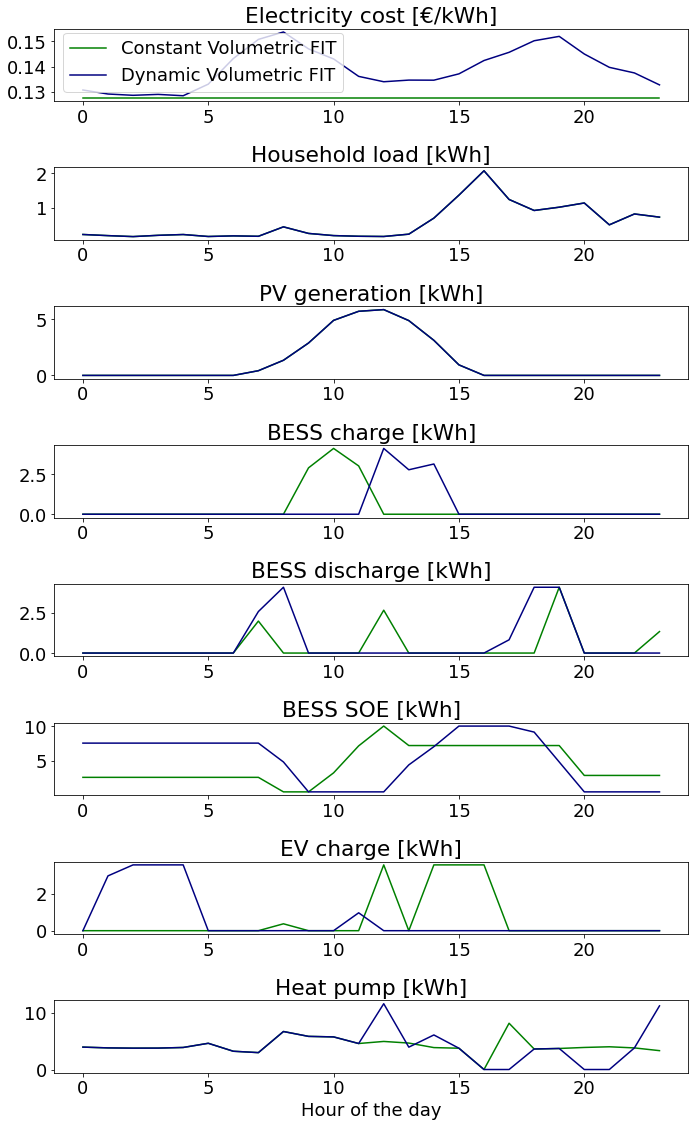

In [501]:

# Plotting
fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(10, 2 * len(cols)))

for idx, col in enumerate(cols):
    axes[idx].plot(temp_results1[col].values, color='green', label=first_case)
    axes[idx].plot(temp_results2[col].values, color='navy', label=second_case)
    axes[idx].set_title(col_namings[idx])
    if idx==0:
        axes[idx].legend()

plt.xlabel("Hour of the day")
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Grid draw [kWh]'}>

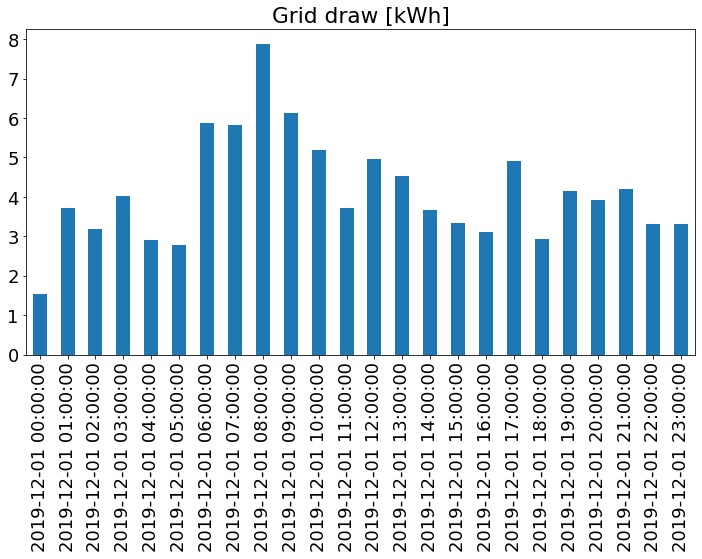

In [443]:
temp_results2["opt_net_energy"].plot.bar(title=("Grid draw [kWh]"))